1. Imports

In [1]:
import os
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt

# Asegura que los plots se vean bien
plt.rcParams["figure.figsize"] = (10, 6)

print("Librerías cargadas correctamente.")



c:\IA_Investigacion\DetCorr_Limpio\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Librerías cargadas correctamente.


2. Cargar modelo y datos

In [2]:
def find_project_root(start_path):
    current = start_path
    while True:
        if os.path.exists(os.path.join(current, ".git")):
            return current
        parent = os.path.dirname(current)
        if parent == current:
            raise RuntimeError("No se encontró la raíz del proyecto (.git).")
        current = parent

PROJECT_ROOT = find_project_root(os.getcwd())
DATA_PROCESSED = os.path.join(PROJECT_ROOT, "data", "processed")
MODELS_DIR = os.path.join(PROJECT_ROOT, "models", "sprint4")
SHAP_DIR = os.path.join(MODELS_DIR, "shap")
os.makedirs(SHAP_DIR, exist_ok=True)

DATASET_PATH = os.path.join(DATA_PROCESSED, "dataset_modelado.parquet")

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATASET_PATH:", DATASET_PATH)
print("MODELS_DIR:", MODELS_DIR)



PROJECT_ROOT: c:\IA_Investigacion\DetCorr_Limpio
DATASET_PATH: c:\IA_Investigacion\DetCorr_Limpio\data\processed\dataset_modelado.parquet
MODELS_DIR: c:\IA_Investigacion\DetCorr_Limpio\models\sprint4


In [3]:
df = pd.read_parquet(DATASET_PATH)

# Detectar el modelo final guardado
model_files = [f for f in os.listdir(MODELS_DIR) if f.startswith("modelo_final")]
assert len(model_files) > 0, "No se encontró modelo final en models/sprint4"

best_model_path = os.path.join(MODELS_DIR, model_files[0])
model = joblib.load(best_model_path)

print("Modelo cargado:", best_model_path)

df.head()



Modelo cargado: c:\IA_Investigacion\DetCorr_Limpio\models\sprint4\modelo_final_RandomForest.pkl


,CODIGO_UNICO,SECTOR,DEPARTAMENTO,NIVEL_GOBIERNO,PROCESO,OBJETO_PROCESO,CODIGO_OBRA,METODO_CONTRATACION,TIEMPO_ABSOLUCION_CONSULTAS,TIEMPO_PRESENTACION_OFERTAS,...,MES,PLANIFICADO,REAL,IND_INTERVENSION,IND_RESIDENTE,IND_MONTO_ADELANTO_MATERIALES,IND_MONTO_ADELANTO_DIRECTO,IND_FECHA_ADELANTO_MATERIALES,IND_FECHA_ADELANTO_DIRECTO,riesgo
0,2002060.0,TRANSPORTE,MULTIDEPARTAMENTAL,GOBIERNO NACIONAL,3.0,CONSULTORÍA DE OBRA,19777.0,CONCURSO PÚBLICO,0.0,0.0,...,4.0,0.185,0.1,DESCONOCIDO,DESCONOCIDO,DESCONOCIDO,DESCONOCIDO,-1,-1,0.0
1,2002210.0,TRANSPORTE,MULTIDEPARTAMENTAL,GOBIERNO NACIONAL,60.0,CONSULTORÍA DE OBRA,826.0,CONCURSO PÚBLICO,0.0,0.0,...,4.0,0.185,0.1,DESCONOCIDO,DESCONOCIDO,DESCONOCIDO,DESCONOCIDO,-1,-1,0.0
2,2002210.0,TRANSPORTE,MULTIDEPARTAMENTAL,GOBIERNO NACIONAL,60.0,CONSULTORÍA DE OBRA,826.0,CONCURSO PÚBLICO,0.0,0.0,...,4.0,0.185,0.1,DESCONOCIDO,DESCONOCIDO,DESCONOCIDO,DESCONOCIDO,-1,-1,0.0
3,2015918.0,TRANSPORTE,MULTIDEPARTAMENTAL,GOBIERNO NACIONAL,24.0,CONSULTORÍA DE OBRA,45660.0,CONCURSO PÚBLICO,0.0,0.0,...,4.0,0.185,0.1,DESCONOCIDO,DESCONOCIDO,DESCONOCIDO,DESCONOCIDO,-1,-1,0.0
4,2026767.0,TRANSPORTE,MULTIDEPARTAMENTAL,GOBIERNO NACIONAL,14.0,CONSULTORÍA DE OBRA,143536.0,CONCURSO PÚBLICO,0.0,0.0,...,4.0,0.185,0.1,DESCONOCIDO,DESCONOCIDO,DESCONOCIDO,DESCONOCIDO,-1,-1,0.0


3. Separar X e y

In [4]:
y = df["riesgo"]
X = df.drop(columns=["riesgo"])

categoricas = X.select_dtypes(include=["object"]).columns.tolist()
numericas = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Categóricas:", categoricas)
print("Numéricas:", numericas)


Categóricas: ['CODIGO_UNICO', 'SECTOR', 'DEPARTAMENTO', 'NIVEL_GOBIERNO', 'OBJETO_PROCESO', 'METODO_CONTRATACION', 'ESTADO_OBRA', 'ETAPA', 'IND_INTERVENSION', 'IND_RESIDENTE', 'IND_MONTO_ADELANTO_MATERIALES', 'IND_MONTO_ADELANTO_DIRECTO']
Numéricas: ['PROCESO', 'CODIGO_OBRA', 'TIEMPO_ABSOLUCION_CONSULTAS', 'TIEMPO_PRESENTACION_OFERTAS', 'CODIGO_RUC', 'CONVOCATORIA_PROCESO_GANADO', 'TOTALPROCESOSPARTICIPANTES', 'CODIGO_CONTRATO', 'MONTO_CONTRACTUAL', 'MONTO_REFERENCIAL', 'MONTO_OFERTADO_PROMEDIO', 'CONVOCATORIA', 'DNI_MIEMBRO_COMITE', 'CODIGO_RUC_GANADOR', 'CODIGO_RUC_PARTICIPANTE', 'RUC_GANADOR', 'RUC_PARTICIPANTE', 'MONTO_OFERTADO', 'DIAS_PLAZO', 'TOTAL_CONTROL_PREVIO', 'TOTAL_CONTROL_SIMULTANEO', 'TOTAL_CONTROL_POSTERIOR', 'RIESGO_OBRA', 'ANHO', 'MES', 'PLANIFICADO', 'REAL', 'IND_FECHA_ADELANTO_MATERIALES', 'IND_FECHA_ADELANTO_DIRECTO']


4. Obtener el preprocesador y el modelo interno

In [5]:
preprocess = model.named_steps["prep"]
modelo_clf = model.named_steps["clf"]

print("Preprocesador y modelo interno identificados:")
print(type(preprocess))
print(type(modelo_clf))



Preprocesador y modelo interno identificados:
<class 'sklearn.compose._column_transformer.ColumnTransformer'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


5. Transformar X usando el mismo pipeline

In [6]:
X_transformed = preprocess.transform(X)

print("Transformación completada.")
print("Forma original:", X.shape)
print("Forma transformada:", X_transformed.shape)


Transformación completada.
Forma original: (14179, 41)
Forma transformada: (14179, 285)


6. Inicializar SHAP dependiendo del modelo

In [7]:
# Modo compatible con scikit-learn y XGBoost
explainer = shap.Explainer(modelo_clf, X_transformed)

print("Explainer SHAP inicializado.")



Explainer SHAP inicializado.


7. Calcular valores SHAP

In [8]:
shap_values = explainer(X_transformed, check_additivity=False)
print("Valores SHAP generados.")


100%|===================| 28354/28358 [46:49<00:00]        

Valores SHAP generados.


8. Summary plot (Global Importance)

In [9]:
print("Tipo de shap_values:", type(shap_values))
print("Shape de shap_values:", np.array(shap_values).shape)
print("Shape de X_transformed:", X_transformed.shape)

print("Primeros 5 SHAP:", np.array(shap_values)[:5])
print("Columnas de X_transformed:", X_transformed[:1])


Tipo de shap_values: <class 'shap._explanation.Explanation'>
Shape de shap_values: (14179, 285, 2)
Shape de X_transformed: (14179, 285)
Primeros 5 SHAP: [[[.values =
   np.float64(-0.09236745508340846)

   .base_values =
   np.float64(0.7294628296703302)

   .data =
   np.float64(1.0)                  .values =
                                    np.float64(0.09236745124878099)

                                    .base_values =
                                    np.float64(0.27053717032967056)

                                    .data =
                                    np.float64(1.0)                ]
  [.values =
   np.float64(0.0)

   .base_values =
   np.float64(0.7294628296703302)

   .data =
   np.float64(0.0)                .values =
                                  np.float64(0.0)

                                  .base_values =
                                  np.float64(0.27053717032967056)

                                  .data =
                                  n

summary_plot guardado en: c:\IA_Investigacion\DetCorr_Limpio\models\sprint4\shap\summary_plot.png


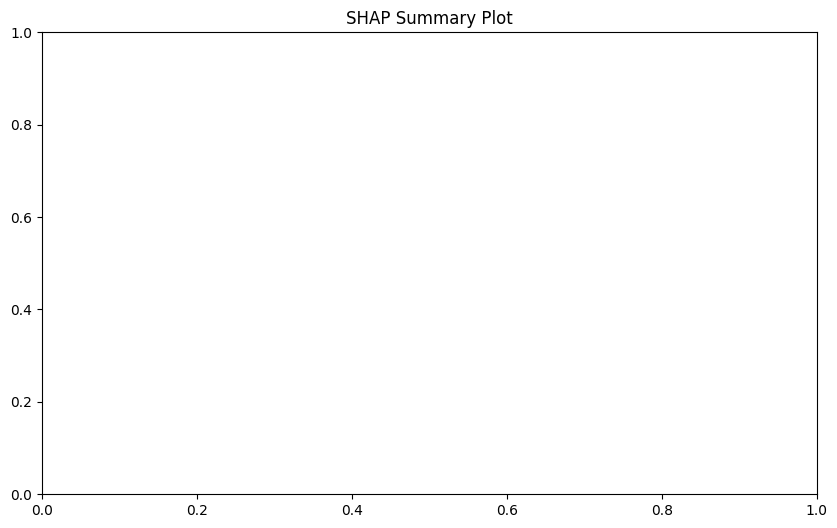

In [10]:
plt.title("SHAP Summary Plot")
shap.summary_plot(shap_values, X_transformed, show=False)

output_path = os.path.join(SHAP_DIR, "summary_plot.png")
plt.savefig(output_path, bbox_inches='tight')
plt.close()

print("summary_plot guardado en:", output_path)



9. Feature Importance Bar Plot

bar_plot guardado en: c:\IA_Investigacion\DetCorr_Limpio\models\sprint4\shap\bar_plot.png


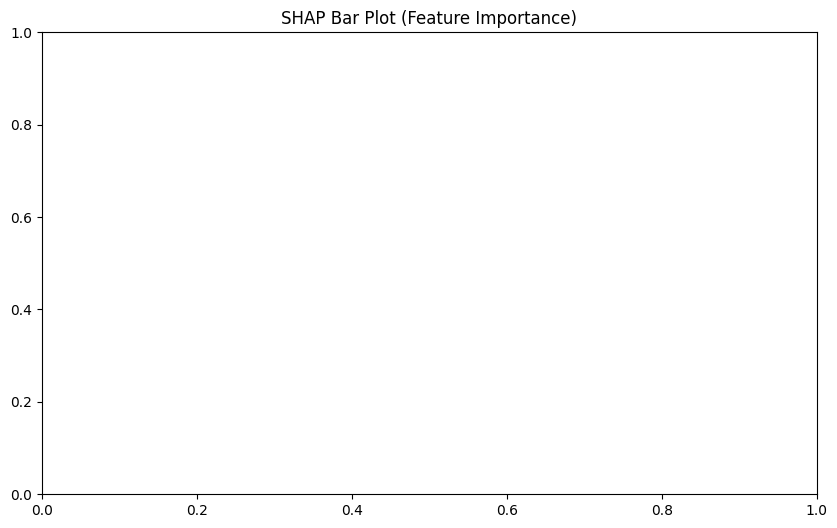

In [11]:
plt.title("SHAP Bar Plot (Feature Importance)")
shap.summary_plot(shap_values, X_transformed, plot_type="bar", show=False)

output_path = os.path.join(SHAP_DIR, "bar_plot.png")
plt.savefig(output_path, bbox_inches='tight')
plt.close()

print("bar_plot guardado en:", output_path)



10. Analizar 5 casos aleatorios

In [12]:
idx_muestras = np.random.choice(len(X), size=5, replace=False)
idx_muestras


array([ 6895, 11660, 14086,  7902,  3285], dtype=int32)

11. Force Plots para cada caso

In [ ]:
import matplotlib.pyplot as plt
import shap
import numpy as np
import os

# Seleccionar algunos ejemplos (5 por defecto)
indices = np.random.choice(len(X_transformed), size=5, replace=False)

for i, idx in enumerate(indices):
    shap_vals_row = shap_values.values[idx]
    features_row = X_transformed.iloc[idx]

    plt.figure(figsize=(10, 3))
    shap.plots.force(
        base_value=explainer.expected_value,
        shap_values=shap_vals_row,
        features=features_row,
        matplotlib=True,
        show=False
    )
    
    path = os.path.join(SHAP_DIR, f"force_plot_{i}.png")
    plt.savefig(path, bbox_inches="tight")
    plt.close()

    print(f"Force plot guardado en: {path}")


TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

<Figure size 1000x600 with 0 Axes>

12. Waterfall Plot (detalle SHAP por caso)

In [ ]:
for i, idx in enumerate(idx_muestras):
    plt.figure()
    shap.plots.waterfall(shap_values[idx], show=False)
    path = os.path.join(SHAP_DIR, f"waterfall_{i}.png")
    plt.savefig(path, bbox_inches='tight')
    plt.close()
    print("Guardado:", path)


13. Dependence Plot para top 5 features

In [ ]:
# Identificar top features
shap_abs = np.abs(shap_values.values).mean(axis=0)
top5_idx = np.argsort(shap_abs)[-5:]

for idx in top5_idx:
    plt.figure()
    shap.dependence_plot(idx, shap_values.values, X_transformed, show=False)
    path = os.path.join(SHAP_DIR, f"dependence_{idx}.png")
    plt.savefig(path, bbox_inches='tight')
    plt.close()
    print("Guardado:", path)


14. Resumen final

In [ ]:
print("Explicabilidad generada.")
print("Imágenes SHAP guardadas en:", SHAP_DIR)
